# Practice Session 09: Forecasting

In this session we will do some time series forecasting on a weather-related time series, which contains temperature, precipitation, and wind speed data for the Barcelona airport. 

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Author: <font color="blue">Shaoya Zhang</font>

E-mail: <font color="blue">shaoya.zhang01@estudiant.upf.edu</font>

Date: <font color="blue">2025-11-27</font>

In [4]:
import io
import json
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math
import warnings

In [5]:
warnings.filterwarnings("ignore")

# 1. Dataset

In [6]:
# LEAVE AS-IS

INPUT_FILE = "aemet-barcelona-airport-2016-2025.json"
weather = pd.read_json(INPUT_FILE)

display(weather.head(5))
display(weather.tail(5))

,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,...,sol,presMax,horaPresMax,presMin,horaPresMin,hrMedia,hrMax,horaHrMax,hrMin,horaHrMin
0,2016-07-01,0201D,BARCELONA,BARCELONA,6,"24,1","0,0","21,9",03:40,"26,3",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-02,0201D,BARCELONA,BARCELONA,6,"24,6","0,0","22,3",04:40,"27,0",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03,0201D,BARCELONA,BARCELONA,6,"23,4","0,0","21,9",11:00,"24,9",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-04,0201D,BARCELONA,BARCELONA,6,"23,8","0,0","21,8",04:40,"25,9",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-05,0201D,BARCELONA,BARCELONA,6,"25,3","0,0","23,2",00:10,"27,4",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,...,sol,presMax,horaPresMax,presMin,horaPresMin,hrMedia,hrMax,horaHrMax,hrMin,horaHrMin
3334,2025-08-19,0076,BARCELONA AEROPUERTO,BARCELONA,4,"27,8","0,7","25,5",Varias,"30,0",...,"4,1","1014,8",Varias,"1009,5",Varias,71.0,82.0,Varias,42.0,08:24
3335,2025-08-20,0076,BARCELONA AEROPUERTO,BARCELONA,4,"24,2","32,9","19,8",22:43,"28,5",...,"5,0","1011,2",Varias,"1007,9",17,62.0,94.0,Varias,54.0,11:28
3336,2025-08-21,0076,BARCELONA AEROPUERTO,BARCELONA,4,"24,4","0,0","19,5",05:11,"29,2",...,"9,0","1014,2",Varias,"1009,2",04,58.0,92.0,00:19,41.0,14:04
3337,2025-08-22,0076,BARCELONA AEROPUERTO,BARCELONA,4,"24,9","0,0","21,3",04:25,"28,5",...,"9,7","1016,0",Varias,"1013,4",04,65.0,82.0,Varias,48.0,09:42
3338,2025-08-23,0076,BARCELONA AEROPUERTO,BARCELONA,4,"25,1","0,0","21,3",05:42,"28,9",...,"11,9","1016,1",Varias,"1013,0",18,71.0,86.0,Varias,60.0,08:48


In [7]:
# LEAVE AS-IS

COLUMN_NAMES = {
  "fecha" : "date",
  "indicativo" : "station_num",
  "nombre" : "station_name",
  "provincia" : "station_province",
  "altitud" : "station_altitude",
  "tmed" : "temp_avg",
  "tmin" : "temp_min",
  "tmax" : "temp_max",
  "horatmin" : "temp_min_time",
  "horatmax" : "temp_max_time",
  "prec" : "rainfall",
  "dir" : "windspeed_dir",
  "velmedia" : "windspeed_avg",
  "racha" : "windspeed_gusts",
  "horaracha" : "windspeed_gusts_time",
  "sol" : "sun",
  "presMax" : "pressure_max",
  "horaPresMax" : "pressure_max_time",
  "presMin" : "pressure_min",
  "horaPresMin" : "pressure_min_time",
  "hrMedia": "relhumidity_mean",
  "hrMax": "relhumidity_max",
  "hrMin": "relhumidity_min",
  "horaHrMax": "relhumidity_max_time", 
  "horaHrMin": "relhumidity_min_time"
}

<font size="+1" color="red">Replace this cell with your code to rename column names in the resulting dataframe.</font>

In [8]:
weather = weather.rename(columns=COLUMN_NAMES)
display(weather.head())

,date,station_num,station_name,station_province,station_altitude,temp_avg,rainfall,temp_min,temp_min_time,temp_max,...,sun,pressure_max,pressure_max_time,pressure_min,pressure_min_time,relhumidity_mean,relhumidity_max,relhumidity_max_time,relhumidity_min,relhumidity_min_time
0,2016-07-01,0201D,BARCELONA,BARCELONA,6,"24,1","0,0","21,9",03:40,"26,3",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-02,0201D,BARCELONA,BARCELONA,6,"24,6","0,0","22,3",04:40,"27,0",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03,0201D,BARCELONA,BARCELONA,6,"23,4","0,0","21,9",11:00,"24,9",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-04,0201D,BARCELONA,BARCELONA,6,"23,8","0,0","21,8",04:40,"25,9",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-05,0201D,BARCELONA,BARCELONA,6,"25,3","0,0","23,2",00:10,"27,4",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<font size="+1" color="red">Replace this cell with your code to drop the station_num, station_name, station_province, station_altitude, and time_* columns, which we will not use, and print the first 10 rows of the data</font>

In [9]:
# print(weather.columns)
drop_names = ['station_num', 'station_name', 'station_province', 'station_altitude', 
              'temp_min_time', 'temp_max_time', 'windspeed_gusts_time', 
              'pressure_max_time', 'pressure_min_time', 
              'relhumidity_max_time', 'relhumidity_min_time']
weather.drop(columns=drop_names, inplace=True, errors='ignore')
display(weather.head(10))


,date,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min,relhumidity_mean,relhumidity_max,relhumidity_min
0,2016-07-01,"24,1","0,0","21,9","26,3",99.0,"3,1","5,8",NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-02,"24,6","0,0","22,3","27,0",13.0,"3,6","7,5",NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03,"23,4","0,0","21,9","24,9",20.0,"4,2","8,9",NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-04,"23,8","0,0","21,8","25,9",25.0,"3,3","6,7",NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-05,"25,3","0,0","23,2","27,4",35.0,"3,1","6,4",NaN,NaN,NaN,NaN,NaN,NaN
5,2016-07-06,"25,8","0,0","23,1","28,5",20.0,"5,0","11,7",NaN,NaN,NaN,NaN,NaN,NaN
6,2016-07-07,"25,4","0,0","23,7","27,1",99.0,"3,9","10,3",NaN,NaN,NaN,NaN,NaN,NaN
7,2016-07-08,"26,2","0,1","24,0","28,4",23.0,"2,5","10,6",NaN,NaN,NaN,NaN,NaN,NaN
8,2016-07-09,"26,6","0,0","24,8","28,5",18.0,"3,1","6,7",NaN,NaN,NaN,NaN,NaN,NaN
9,2016-07-10,"26,8","0,0","24,9","28,6",19.0,"4,7","9,2",NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# LEAVE THIS CODE AS-IS

display(weather.head(5))
display(weather.tail(5))

,date,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min,relhumidity_mean,relhumidity_max,relhumidity_min
0,2016-07-01,"24,1","0,0","21,9","26,3",99.0,"3,1","5,8",NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-02,"24,6","0,0","22,3","27,0",13.0,"3,6","7,5",NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03,"23,4","0,0","21,9","24,9",20.0,"4,2","8,9",NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-04,"23,8","0,0","21,8","25,9",25.0,"3,3","6,7",NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-05,"25,3","0,0","23,2","27,4",35.0,"3,1","6,4",NaN,NaN,NaN,NaN,NaN,NaN


,date,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min,relhumidity_mean,relhumidity_max,relhumidity_min
3334,2025-08-19,"27,8","0,7","25,5","30,0",34.0,"5,0","12,5","4,1","1014,8","1009,5",71.0,82.0,42.0
3335,2025-08-20,"24,2","32,9","19,8","28,5",4.0,"4,2","14,4","5,0","1011,2","1007,9",62.0,94.0,54.0
3336,2025-08-21,"24,4","0,0","19,5","29,2",99.0,"4,7","8,9","9,0","1014,2","1009,2",58.0,92.0,41.0
3337,2025-08-22,"24,9","0,0","21,3","28,5",35.0,"5,0","10,8","9,7","1016,0","1013,4",65.0,82.0,48.0
3338,2025-08-23,"25,1","0,0","21,3","28,9",24.0,"5,8","11,4","11,9","1016,1","1013,0",71.0,86.0,60.0


<font size="+1" color="red">Replace this cell with your code implementing *str_commas_to_float*.</font>

In [11]:
def str_commas_to_float(x):
    # Case 1: already a float or int → return float
    if isinstance(x, float) or isinstance(x, int):
        return float(x)

    # Case 2: non-string → NaN
    if not isinstance(x, str):
        return np.nan

    # Case 3: string
    x = x.strip()
    if x.lower() == 'ip':
        return 0.0
    try:
        return float(x.replace(',', '.'))
    except:
        return np.nan

<font size="+1" color="red">Replace this cell with your code testing *str_commas_to_float*.</font>

In [12]:
assert np.isnan(str_commas_to_float(""))
assert np.isnan(str_commas_to_float("Varias"))
assert np.isnan(str_commas_to_float("06:30"))

assert str_commas_to_float("0,0") == 0.0
assert str_commas_to_float("Ip") == 0.0
assert str_commas_to_float("13,5") == 13.5
assert str_commas_to_float("13") == 13.0

# string with space
assert str_commas_to_float(" 13,5 ") == 13.5
assert str_commas_to_float(" Ip ") == 0.0

assert str_commas_to_float(15) == 15.0

<font size="+1" color="red">Replace this cell with your code applying the above function to the specified columns.</font>

In [13]:
weather['temp_max'] = weather['temp_max'].apply(str_commas_to_float)
weather['temp_min'] = weather['temp_min'].apply(str_commas_to_float)
weather['temp_avg'] = weather['temp_avg'].apply(str_commas_to_float)
weather['rainfall'] = weather['rainfall'].apply(str_commas_to_float)
weather['windspeed_dir'] = weather['windspeed_dir'].apply(str_commas_to_float)
weather['windspeed_avg'] = weather['windspeed_avg'].apply(str_commas_to_float)
weather['windspeed_gusts'] = weather['windspeed_gusts'].apply(str_commas_to_float)
weather['pressure_max'] = weather['pressure_max'].apply(str_commas_to_float)
weather['pressure_min'] = weather['pressure_min'].apply(str_commas_to_float)
weather['relhumidity_min'] = weather['relhumidity_min'].apply(str_commas_to_float)
weather['relhumidity_max'] = weather['relhumidity_max'].apply(str_commas_to_float)


In [14]:
# LEAVE THIS CODE AS-IS

display(weather.head(5))
display(weather.tail(5))

,date,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min,relhumidity_mean,relhumidity_max,relhumidity_min
0,2016-07-01,24.1,0.0,21.9,26.3,99.0,3.1,5.8,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-02,24.6,0.0,22.3,27.0,13.0,3.6,7.5,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03,23.4,0.0,21.9,24.9,20.0,4.2,8.9,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-04,23.8,0.0,21.8,25.9,25.0,3.3,6.7,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-05,25.3,0.0,23.2,27.4,35.0,3.1,6.4,NaN,NaN,NaN,NaN,NaN,NaN


,date,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min,relhumidity_mean,relhumidity_max,relhumidity_min
3334,2025-08-19,27.8,0.7,25.5,30.0,34.0,5.0,12.5,"4,1",1014.8,1009.5,71.0,82.0,42.0
3335,2025-08-20,24.2,32.9,19.8,28.5,4.0,4.2,14.4,"5,0",1011.2,1007.9,62.0,94.0,54.0
3336,2025-08-21,24.4,0.0,19.5,29.2,99.0,4.7,8.9,"9,0",1014.2,1009.2,58.0,92.0,41.0
3337,2025-08-22,24.9,0.0,21.3,28.5,35.0,5.0,10.8,"9,7",1016.0,1013.4,65.0,82.0,48.0
3338,2025-08-23,25.1,0.0,21.3,28.9,24.0,5.8,11.4,"11,9",1016.1,1013.0,71.0,86.0,60.0


In [15]:
# LEAVE AS-IS

weather.set_index('date', inplace=True)
weather.index = pd.to_datetime(weather.index)
display(weather.head(3))

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min,relhumidity_mean,relhumidity_max,relhumidity_min
date,,,,,,,,,,,,,
2016-07-01,24.1,0.0,21.9,26.3,99.0,3.1,5.8,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-02,24.6,0.0,22.3,27.0,13.0,3.6,7.5,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-03,23.4,0.0,21.9,24.9,20.0,4.2,8.9,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# LEAVE THIS CELL AS-IS

# Configure font sizes
plt.rc('font', size=10) 
plt.rc('axes', labelsize=16)
plt.rc('legend', fontsize=16)

# Flexible plotting function

def plot_min_max(df, min_col='', max_col='', avg_col='', avg_label='Average', 
                     title='Weather', xlabel='Date', ylabel='Variable'):

    # Create a figure
    plt.figure(figsize=(16,5))

    # Plot for dates
    if avg_col:
        plt.plot_date(df.index, df[avg_col],
                      fmt='.-', color='black', label=avg_label)
    if min_col and max_col:
        plt.fill_between(df.index, df[min_col], df[max_col],
                         color='lightgray')
    if avg_col:
        plt.legend()

    # Label axis
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()
    
# Simple version


# Plot function
def plot_variable(df, col='', label='', title='Weather', xlabel='Date', ylabel=''):
    
    plot_min_max(df, title=title, xlabel=xlabel, ylabel=ylabel, avg_col=col, avg_label=label)

    plt.show()


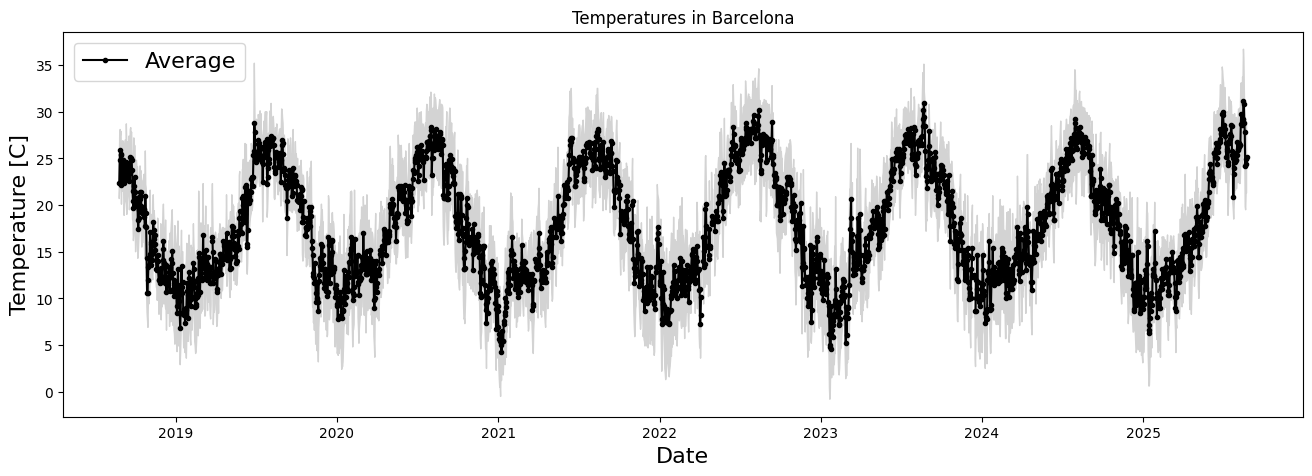

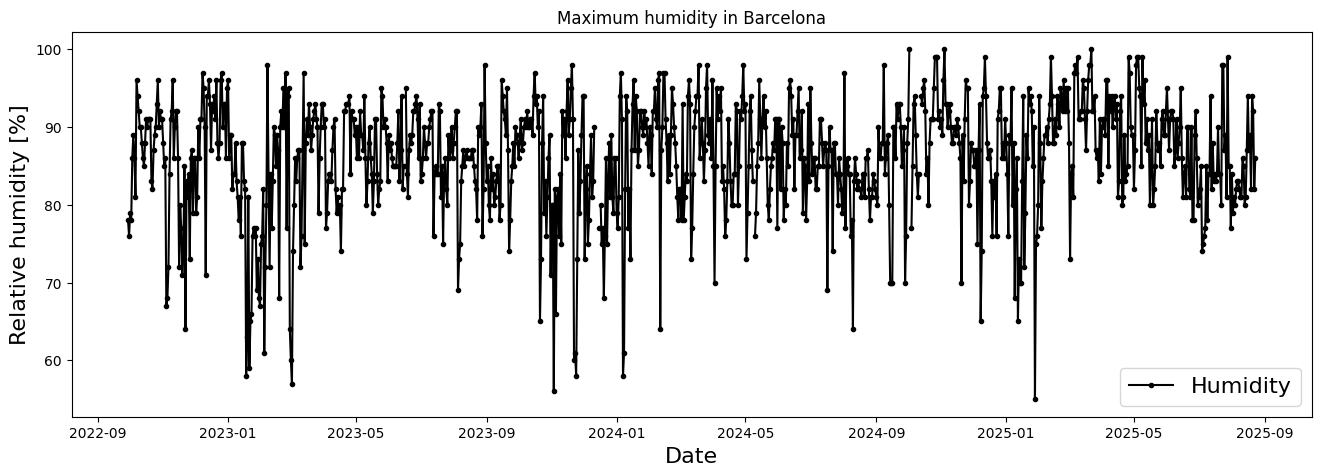

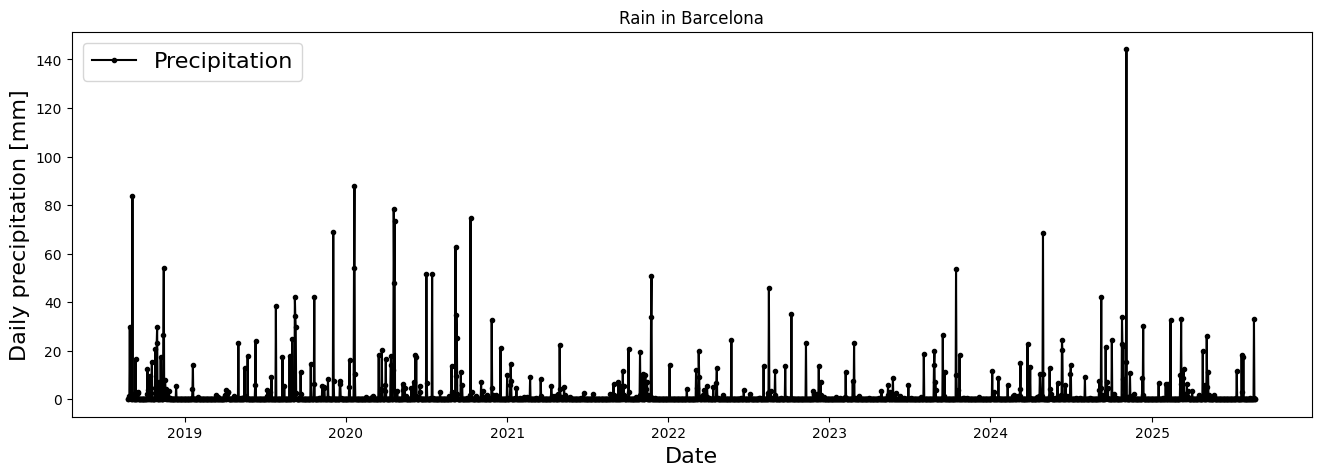

In [17]:
# LEAVE AS-IS

# Retrieve the last 7 years
weather_sample = weather.tail(7*365)

# Plot temperature
plot_min_max(weather_sample, title='Temperatures in Barcelona', ylabel='Temperature [C]',
             min_col='temp_min', max_col='temp_max', avg_col='temp_avg')

# Plot humidity
plot_variable(weather_sample, title='Maximum humidity in Barcelona', ylabel='Relative humidity [%]',
             col='relhumidity_max', label='Humidity')

# Plot precipitation
plot_variable(weather_sample, title='Rain in Barcelona', ylabel='Daily precipitation [mm]', 
            col='rainfall', label='Precipitation')


<font size="+1" color="red">Replace this cell with a brief commentary on these three plots. Answer the following: do you observe seasonality in some/all of these plots? Can you describe what type of seasonality do you observe in that one?</font>

#### Comment
From the above three plots, we can see that temperature exhibits strong and clear yearly seasonality. The pattern is smooth and cyclic, with higher temperatures in the summer months and lower temperatures in winter months. The curve looks similar to a sinusoidal or sigmoid-like annual oscillation.

Relative humidity also shows seasonal variation, but the pattern is weaker and less regular compared to temperature. While there are periods of higher humidityand lower humidity , such as around January of each year, over the year, the fluctuations are not as smooth nor as strongly periodic as those in temperature. This suggests that humidity is influenced not only by seasonal cycles but also by other factors.

# 1. Smooth this series


## 1.1 Smooth the series using moving averages

<font size="+1" color="red">Replace this cell with your implementation of "moving_average"</font>

In [18]:
def moving_average(df, window_size):

    averages = []
    
    for i in range(len(df)):
        
        # Extract a window from the dataframe
        # YOUR CODE HERE
        start = max(0, i - window_size + 1)
        end = i + 1
        window = df.iloc[start : end]
        # Compute the average
        average = window.mean(numeric_only=True)
        
        # Append the average to the list of averages
        averages.append(average)

    # Create the dataframe that will be returned
    smoothed = pd.DataFrame(averages, columns=df.columns)
    smoothed.set_index(df.index, inplace=True)
    
    return smoothed

In [19]:
# LEAVE AS-IS

window_size = 7

weather_smoothed = moving_average(weather, window_size)

weather_smoothed.head(10)

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min,relhumidity_mean,relhumidity_max,relhumidity_min
date,,,,,,,,,,,,,
2016-07-01,24.100000,0.000000,21.900000,26.300000,99.000000,3.100000,5.800000,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-02,24.350000,0.000000,22.100000,26.650000,56.000000,3.350000,6.650000,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-03,24.033333,0.000000,22.033333,26.066667,44.000000,3.633333,7.400000,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-04,23.975000,0.000000,21.975000,26.025000,39.250000,3.550000,7.225000,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-05,24.240000,0.000000,22.220000,26.300000,38.400000,3.460000,7.060000,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-06,24.500000,0.000000,22.366667,26.666667,35.333333,3.716667,7.833333,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-07,24.628571,0.000000,22.557143,26.728571,44.428571,3.742857,8.185714,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-08,24.928571,0.014286,22.857143,27.028571,33.571429,3.657143,8.871429,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-09,25.214286,0.014286,23.214286,27.242857,34.285714,3.585714,8.757143,NaN,NaN,NaN,NaN,NaN,NaN


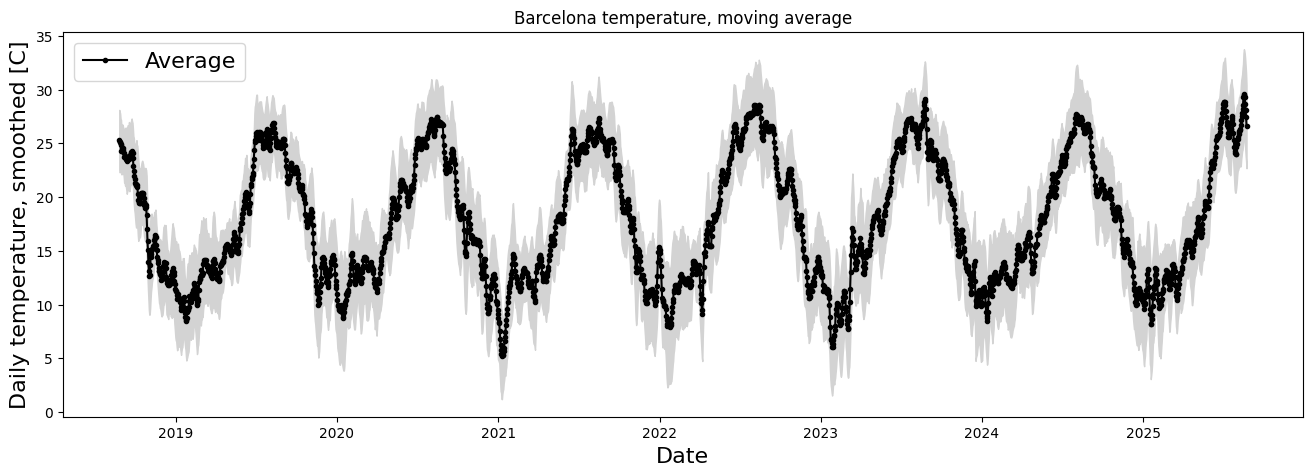

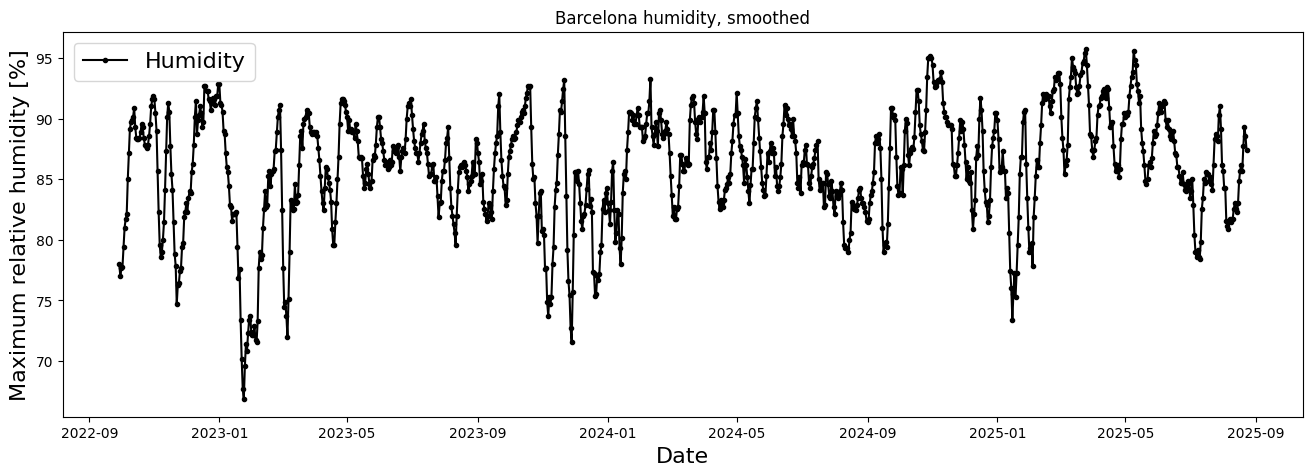

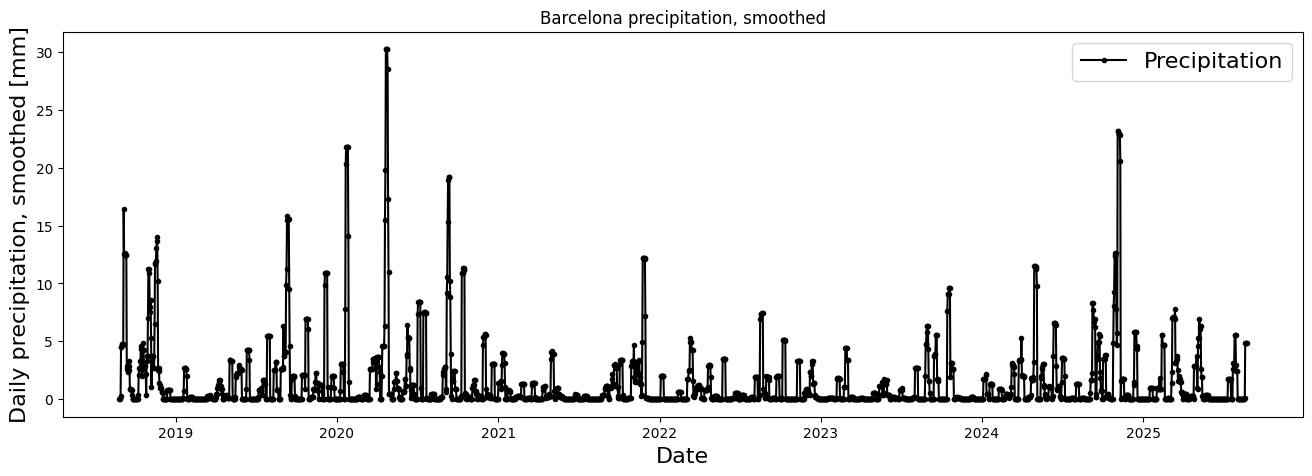

In [20]:
# LEAVE AS-IS

# Sample last 7 years
weather_smoothed_sample = weather_smoothed.tail(7*365)

# Plot smoothed temperature
plot_min_max(weather_smoothed_sample, ylabel='Daily temperature, smoothed [C]',
             title="Barcelona temperature, moving average", 
             min_col='temp_min', max_col='temp_max', avg_col='temp_avg')

# Plot smoothed humidity
plot_variable(weather_smoothed_sample,
              title="Barcelona humidity, smoothed", 
                col="relhumidity_max", label="Humidity", ylabel="Maximum relative humidity [%]")

# Plot smoothed precipitation
plot_variable(weather_smoothed_sample,
              title="Barcelona precipitation, smoothed", 
                col="rainfall", label="Precipitation", ylabel="Daily precipitation, smoothed [mm]")

<font size="+1" color="red">Replace this cell with a brief commentary indicating what are the key difficulties when implementing a function for "moving_average"</font>

#### Comment
Key difficulties when implementing a moving_average function include:

1. Boundary handling – At the start of the series there are fewer points than the window size, so one must decide whether to return NaN, use a smaller window, or begin only after a full window.
2. Missing values – Real data may contain NaNs, and the function must define whether to ignore them, propagate them, or impute them.
3. Window size selection – A small window is sensitive to noise, while a large one over-smooths the series, so choosing an appropriate size is non-trivial.
4. Computational efficiency – Recomputing window sums naively is slow for long series; efficient implementations require cumulative sums or sliding-window updates.
5. Alignment choices – The moving average may be trailing, centered, or leading, and the chosen alignment affects how the result should be interpreted.

<font size="+1" color="red">Replace this cell with code that creates a separate ``test`` dataset, and smooths this ``test`` dataset 20 times. **Do not modify your original dataset**, this is just a test. Plot the smoothed daily temperature and smoothed daily precipitation in the ``test`` dataset.</font>

In [21]:
test = weather.copy()
smooth_times = 20
for _ in range(smooth_times):
    test = moving_average(test, window_size)



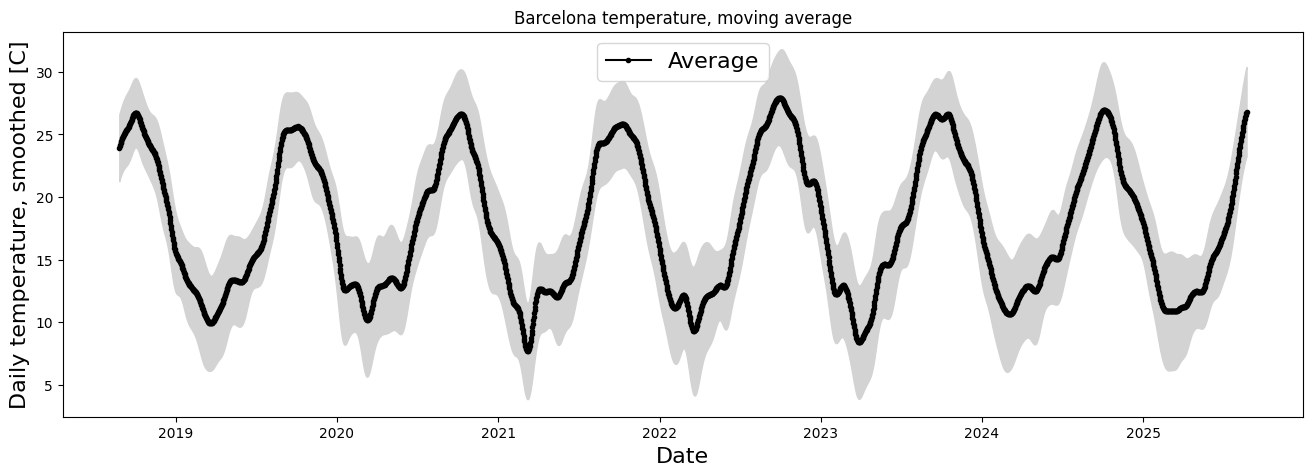

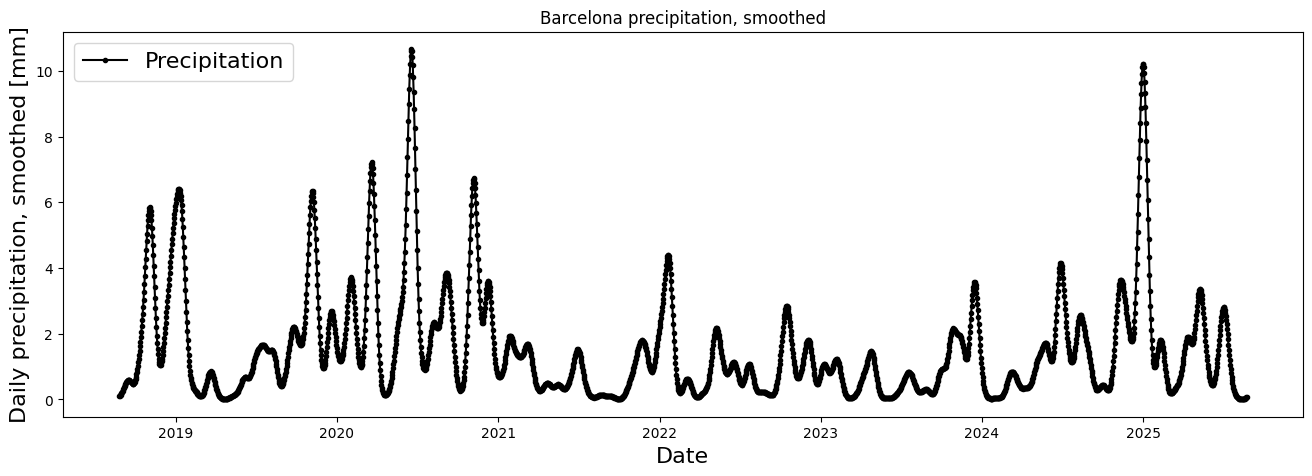

In [22]:
# Sample last 7 years
test_smoothed_sample = test.tail(7*365)

# Plot smoothed temperature
plot_min_max(test_smoothed_sample, ylabel='Daily temperature, smoothed [C]',
             title="Barcelona temperature, moving average", 
             min_col='temp_min', max_col='temp_max', avg_col='temp_avg')

# Plot smoothed precipitation
plot_variable(test_smoothed_sample,
              title="Barcelona precipitation, smoothed", 
                col="rainfall", label="Precipitation", ylabel="Daily precipitation, smoothed [mm]")

<font size="+1" color="red">Replace this cell with a brief commentary on what you see in the repeatedly smoothed dataset. Why does this happen?</font>

#### Comment
After repeated smoothing, the dataset becomes progressively flatter, with peaks and valleys shrinking toward a smooth, almost linear trend. This happens because each round of smoothing averages neighboring values, which reduces variance and removes short-term fluctuations. When smoothing is applied multiple times, the high-frequency components are repeatedly dampened, eventually leaving only the broadest, long-term trend. In the limit, repeated smoothing drives the series toward a constant or slowly varying curve, because almost all local structure has been averaged away.

## 1.2. Smooth the series by binning per floating weeks

<font size="+1" color="red">Replace this cell with your code for "list_of_floating_week_starts"</font>

In [23]:
def list_of_floating_week_starts(first, last):
    weeks = [first]
    
    # YOUR CODE HERE
    
    while weeks[-1] <= last:
        next_week = weeks[-1] + datetime.timedelta(weeks=1)
        weeks.append(next_week)
    return(weeks)

In [24]:
# LEAVE AS-IS

# Remember that our data frame is indexedb by date
first_day = np.min(weather.index)
last_day = np.max(weather.index)

# Obtain the list of weeks
weeks = list_of_floating_week_starts(first_day, last_day)

# Print the list of weeks
print("There are %d week starts" % len(weeks))
print("First week starts %s, last week starts %s" %
      (weeks[0].strftime("%Y-%m-%d"), weeks[-1].strftime("%Y-%m-%d")))

There are 479 week starts
First week starts 2016-07-01, last week starts 2025-08-29


In [25]:
# LEAVE AS-IS

# Create a map from dates to week starts
date_to_week_start= {}
week_num = 0
for date, row in weather.iterrows():
    while not (date >= weeks[week_num] and date < weeks[week_num+1]):
        week_num += 1
    date_to_week_start[date] = weeks[week_num]
    
# Create a new dataframe with an extra column
weather_with_week_start = weather
weather_with_week_start['week_start'] = [date_to_week_start[date] for date in weather.index]
weather_with_week_start.head(10)
# weather_with_week_start.tail(5)

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min,relhumidity_mean,relhumidity_max,relhumidity_min,week_start
date,,,,,,,,,,,,,,
2016-07-01,24.1,0.0,21.9,26.3,99.0,3.1,5.8,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-01
2016-07-02,24.6,0.0,22.3,27.0,13.0,3.6,7.5,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-01
2016-07-03,23.4,0.0,21.9,24.9,20.0,4.2,8.9,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-01
2016-07-04,23.8,0.0,21.8,25.9,25.0,3.3,6.7,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-01
2016-07-05,25.3,0.0,23.2,27.4,35.0,3.1,6.4,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-01
2016-07-06,25.8,0.0,23.1,28.5,20.0,5.0,11.7,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-01
2016-07-07,25.4,0.0,23.7,27.1,99.0,3.9,10.3,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-01
2016-07-08,26.2,0.1,24.0,28.4,23.0,2.5,10.6,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-08
2016-07-09,26.6,0.0,24.8,28.5,18.0,3.1,6.7,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-08


<font size="+1" color="red">Replace this cell with your code to generate the "weather_per_floating_week" dataframe</font>

In [26]:
dic = {'temp_avg': np.mean,
       'temp_min': np.mean,
       'temp_max': np.mean,
       'rainfall': np.sum,
       'relhumidity_mean': np.mean,
       'relhumidity_max': np.mean,
       'relhumidity_min': np.mean
       }
group_week = weather_with_week_start.groupby(by=['week_start'])
weather_per_floating_week = group_week.aggregate(dic)
display(weather_per_floating_week)

,temp_avg,temp_min,temp_max,rainfall,relhumidity_mean,relhumidity_max,relhumidity_min
week_start,,,,,,,
2016-07-01,24.628571,22.557143,26.728571,0.0,NaN,NaN,NaN
2016-07-08,25.314286,23.128571,27.500000,0.4,NaN,NaN,NaN
2016-07-15,24.171429,21.485714,26.871429,0.6,NaN,NaN,NaN
2016-07-22,25.428571,22.542857,28.328571,5.8,NaN,NaN,NaN
2016-07-29,25.957143,24.028571,27.871429,0.6,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-07-25,24.642857,20.957143,28.314286,17.3,59.714286,86.142857,47.571429
2025-08-01,26.185714,23.000000,29.357143,0.0,66.714286,81.714286,55.714286
2025-08-08,28.214286,24.400000,32.000000,0.3,63.571429,82.285714,48.142857


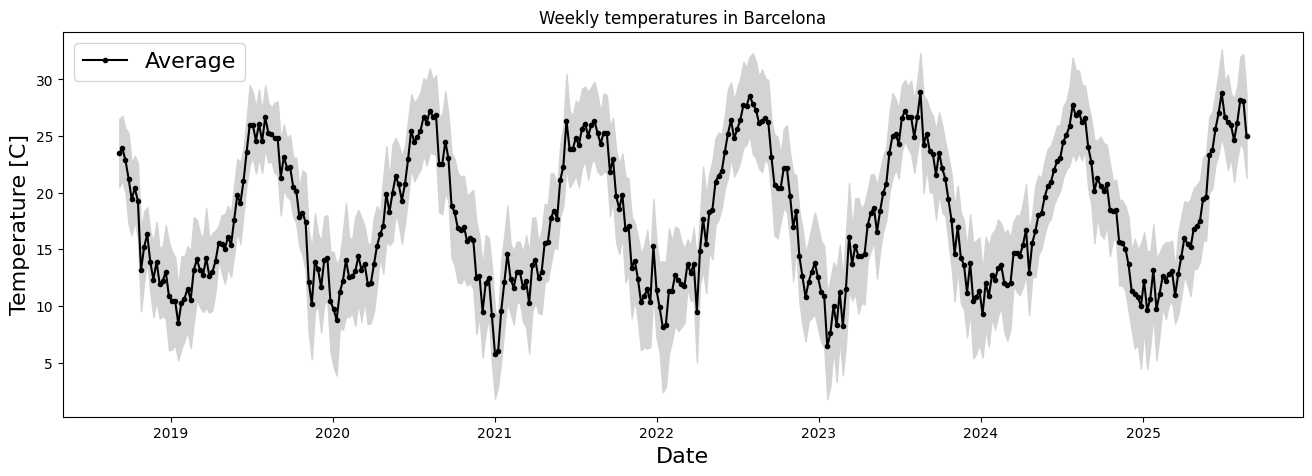

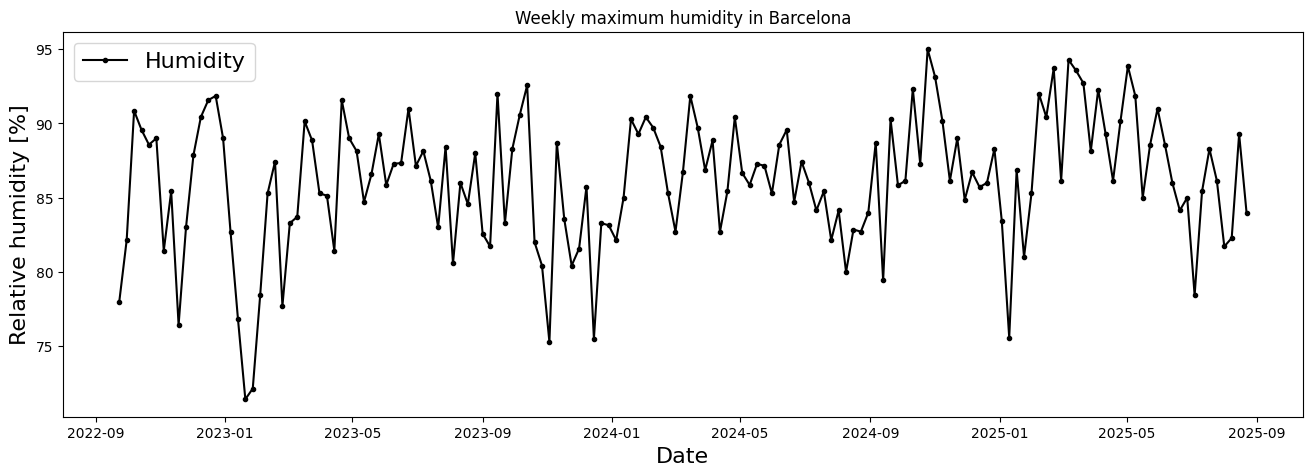

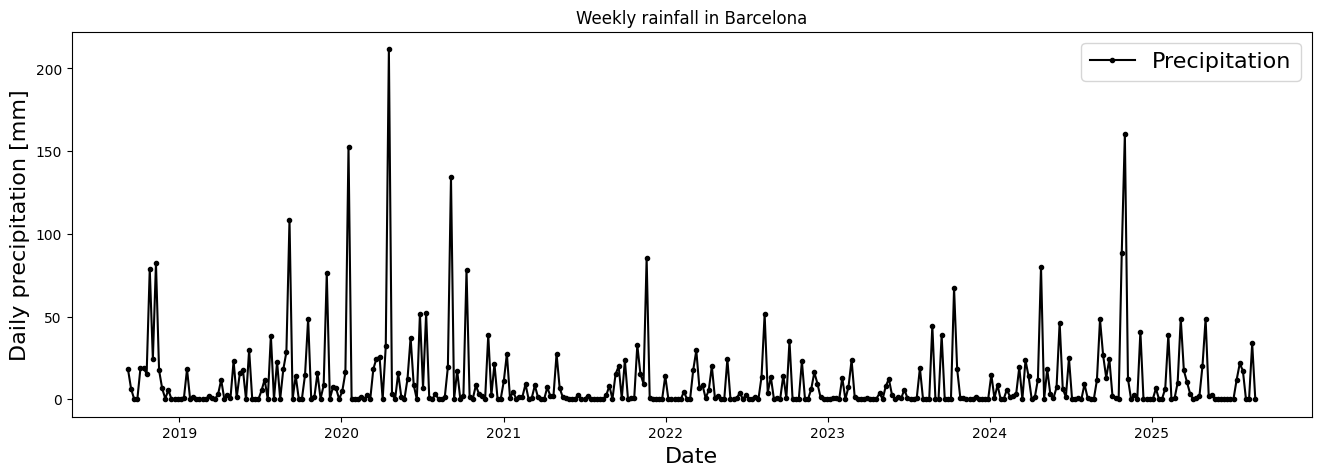

In [27]:
# LEAVE AS-IS

# Retrieve the past 5 years
weather_sample = weather_per_floating_week.tail(7*52)

# Plot temperature
plot_min_max(weather_sample, title='Weekly temperatures in Barcelona', ylabel='Temperature [C]',
             min_col='temp_min', max_col='temp_max', avg_col='temp_avg')

# Plot humidity
plot_variable(weather_sample, title='Weekly maximum humidity in Barcelona', ylabel='Relative humidity [%]',
             col='relhumidity_max', label='Humidity')

# Plot precipitation
plot_variable(weather_sample, title='Weekly rainfall in Barcelona', ylabel='Daily precipitation [mm]', 
            col='rainfall', label='Precipitation')

<font size="+1" color="red">Replace this cell with a brief commentary of what you observe on these plots.</font>

#### Comment
*****

## 1.3. Smooth the series by binning per month

In [28]:
def list_of_month_starts(first, last):
    d1 = first.replace(day= 1)
    months = [d1]
    
    while months[-1] <= last:
        cur_month = months[-1] 
        if cur_month.month < 12:
            next_month  = cur_month.replace(month=cur_month.month + 1)
        else:
            next_month  = cur_month.replace(year=cur_month.year + 1, month=1)
        months.append(next_month)
    return months

In [29]:
# LEAVE AS-IS

first_day = np.min(weather.index)
last_day = np.max(weather.index)
months = list_of_month_starts(first_day, last_day)

print("There are %d month starts" % len(months))
print("First month starts %s, last month starts %s" % (months[0].strftime("%Y-%m-%d"), months[-1].strftime("%Y-%m-%d")))

There are 111 month starts
First month starts 2016-07-01, last month starts 2025-09-01


In [30]:
# LEAVE AS-IS

# Create a map from dates to week starts
date_to_month_start= {}
month_num = 0
for date, row in weather.iterrows():
    while not (date >= months[month_num] and date < months[month_num+1]):
        month_num += 1
    date_to_month_start[date] = months[month_num]
    
# Create a new dataframe with an extra column
weather_with_month_start = weather
weather_with_month_start['month_start'] = [date_to_month_start[date] for date in weather.index]
weather_with_month_start

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min,relhumidity_mean,relhumidity_max,relhumidity_min,week_start,month_start
date,,,,,,,,,,,,,,,
2016-07-01,24.1,0.0,21.9,26.3,99.0,3.1,5.8,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-01,2016-07-01
2016-07-02,24.6,0.0,22.3,27.0,13.0,3.6,7.5,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-01,2016-07-01
2016-07-03,23.4,0.0,21.9,24.9,20.0,4.2,8.9,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-01,2016-07-01
2016-07-04,23.8,0.0,21.8,25.9,25.0,3.3,6.7,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-01,2016-07-01
2016-07-05,25.3,0.0,23.2,27.4,35.0,3.1,6.4,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-01,2016-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-19,27.8,0.7,25.5,30.0,34.0,5.0,12.5,"4,1",1014.8,1009.5,71.0,82.0,42.0,2025-08-15,2025-08-01
2025-08-20,24.2,32.9,19.8,28.5,4.0,4.2,14.4,"5,0",1011.2,1007.9,62.0,94.0,54.0,2025-08-15,2025-08-01
2025-08-21,24.4,0.0,19.5,29.2,99.0,4.7,8.9,"9,0",1014.2,1009.2,58.0,92.0,41.0,2025-08-15,2025-08-01


<font size="+1" color="red">Replace this cell with your code to generate the "weather_per_month" dataframe</font>

In [31]:
group_month = weather_with_month_start.groupby(by=['month_start'])
weather_per_month = group_month.aggregate(dic)
display(weather_per_month)

,temp_avg,temp_min,temp_max,rainfall,relhumidity_mean,relhumidity_max,relhumidity_min
month_start,,,,,,,
2016-07-01,24.996774,22.593548,27.412903,7.4,NaN,NaN,NaN
2016-08-01,24.974074,22.633333,27.318519,8.1,NaN,NaN,NaN
2016-09-01,23.703448,20.758621,26.655172,31.6,NaN,NaN,NaN
2016-10-01,19.365517,16.903448,21.837931,126.7,NaN,NaN,NaN
2016-11-01,15.027586,11.937931,18.100000,31.8,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-04-01,15.610000,12.046667,19.176667,26.0,73.266667,89.833333,56.100000
2025-05-01,18.712903,14.980645,22.432258,53.5,70.225806,89.612903,54.451613
2025-06-01,25.580000,22.160000,29.003333,0.0,67.300000,87.133333,50.433333


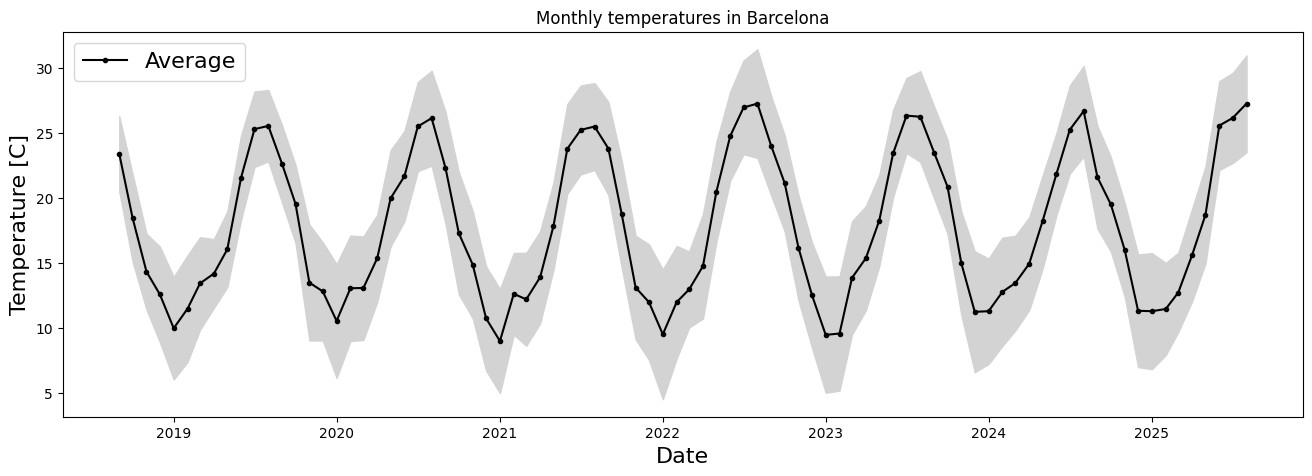

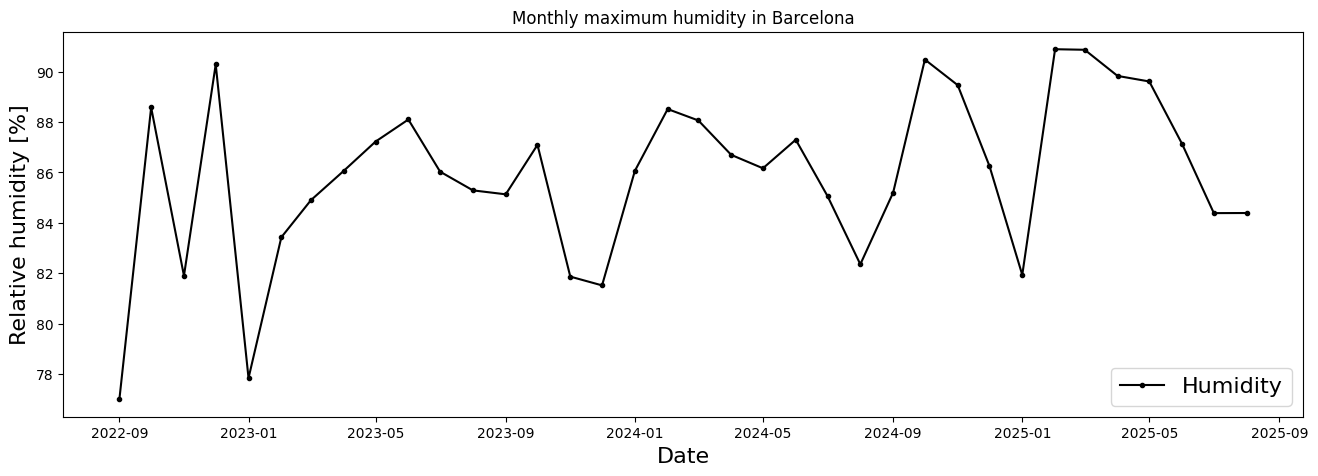

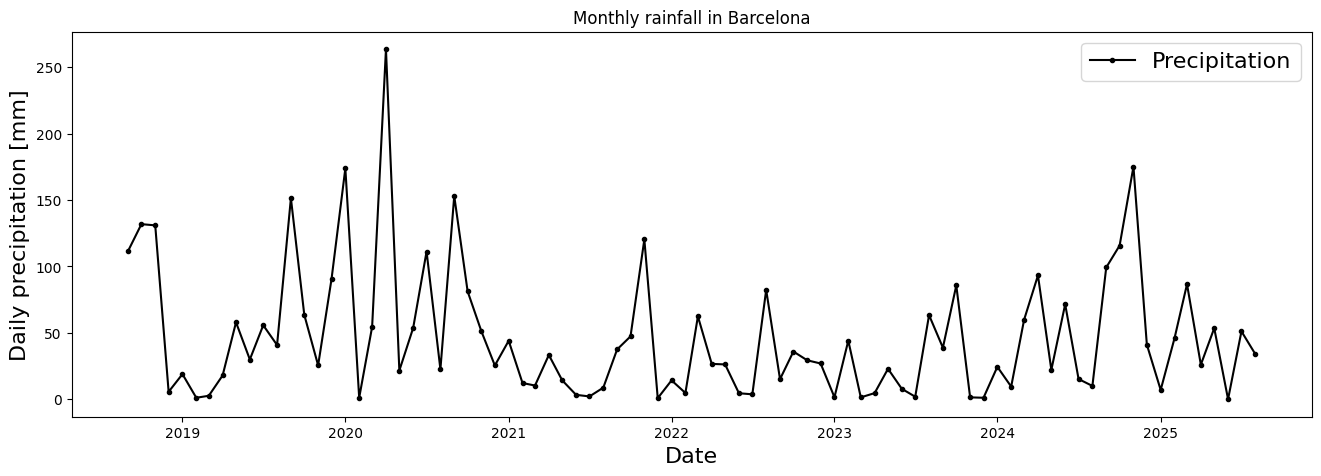

In [32]:
# LEAVE AS-IS

# Retrieve the last 7 years
weather_sample = weather_per_month.tail(7*12)

# Plot temperature
plot_min_max(weather_sample, title='Monthly temperatures in Barcelona', ylabel='Temperature [C]',
             min_col='temp_min', max_col='temp_max', avg_col='temp_avg')

# Plot humidity
plot_variable(weather_sample, title='Monthly maximum humidity in Barcelona', ylabel='Relative humidity [%]',
             col='relhumidity_max', label='Humidity')

# Plot precipitation
plot_variable(weather_sample, title='Monthly rainfall in Barcelona', ylabel='Daily precipitation [mm]', 
            col='rainfall', label='Precipitation')

<font size="+1" color="red">Replace this cell with a brief commentary of what you observe on these plots.</font>

#### Comment
*****

# 2. Perform forecasting

## 2.1. Compute auto-correlation plots

<font size="+1" color="red">Replace this cell with your code for "lagged_series"</font>

In [33]:
def lagged_series(series, lag):
    original_trimmed = []
    lagged = []
    for i in range(len(series)):
        j = i - lag
        # YOUR CODE HERE
        # You have to append series[i] to original and series[j] to lagged
        # but only if j is in [0, len(series)-1]
        if 0 <= j < len(series):
            original_trimmed.append(series[i])
            lagged.append(series[j])
    return original_trimmed, lagged

In [34]:
# LEAVE AS-IS

assert ([44, 55, 66, 77, 88], [11, 22, 33, 44, 55]) == lagged_series([11,22,33,44,55,66,77,88], 3)

assert ([33, 44, 55, 66, 77, 88], [11, 22, 33, 44, 55, 66]) == lagged_series([11,22,33,44,55,66,77,88], 2)

assert ([22, 33, 44, 55, 66, 77, 88], [11, 22, 33, 44, 55, 66, 77]) == lagged_series([11,22,33,44,55,66,77,88], 1)


In [35]:
# LEAVE AS-IS

# Computes the correlation between two vectors, considering
# only the positions in which both vectors are not NaN
def correlation_without_nan(x,y):
    positions_to_remove = ~np.logical_or(np.isnan(x), np.isnan(y))

    x_without_nan = np.compress(positions_to_remove, x)
    y_without_nan = np.compress(positions_to_remove, y)
    return stats.pearsonr(x_without_nan,y_without_nan)[0]  

# Compute autocorrelation
def autocorrelation(series, lag):
    x,y = lagged_series(series, lag)
            
    return correlation_without_nan(x,y)

<font size="+1" color="red">Replace this cell with your code to compute "auto_correlations_temp" and "auto_correlations_rainfall"</font>

In [36]:
def compute_autocorrelations(series, max_periods):
    autocorrs = []
    for lag in range(max_periods):
        ac = autocorrelation(series, lag)
        autocorrs.append(ac)
    return autocorrs

max_periods = 2 * 365
auto_correlations_temp_avg = compute_autocorrelations(weather['temp_avg'], max_periods)
auto_correlations_rainfall = compute_autocorrelations(weather['rainfall'], max_periods)
auto_correlations_temp_max = compute_autocorrelations(weather['temp_max'], max_periods) # 
auto_correlations_relhumidity = compute_autocorrelations(weather['relhumidity_max'], max_periods) #

In [37]:
# LEAVE AS-IS

def plot_auto_correlations(correlations, xlabel="Lag (days)", ylabel="Autocorrelation"):
    # Figure
    plt.figure(figsize=(15,4))

    # Plot correlation
    plt.plot(range(len(correlations)), correlations, '-o')

    # Add xticks every 10 periods
    plt.xticks(np.arange(0, len(correlations), 10), rotation=90)

    # Add a horizontal line at zero
    plt.hlines(0, xmin=0, xmax=len(correlations))

    # Add labels
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

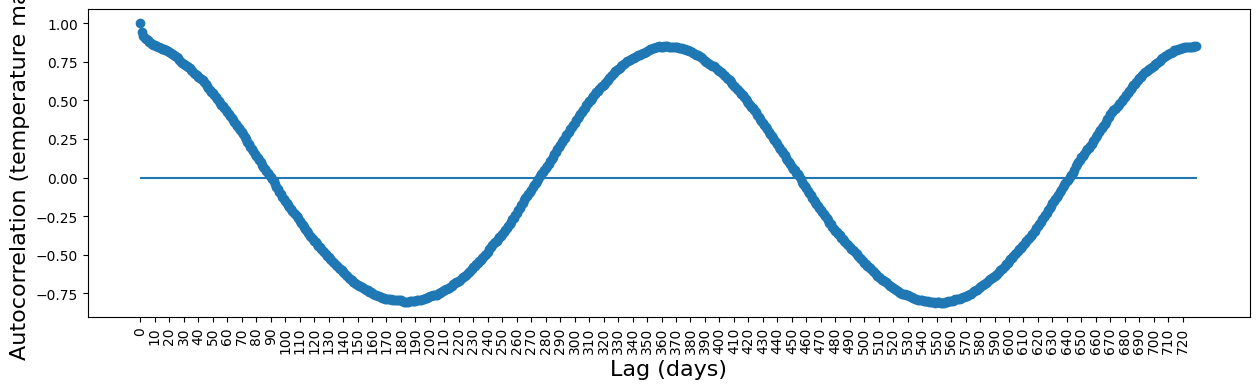

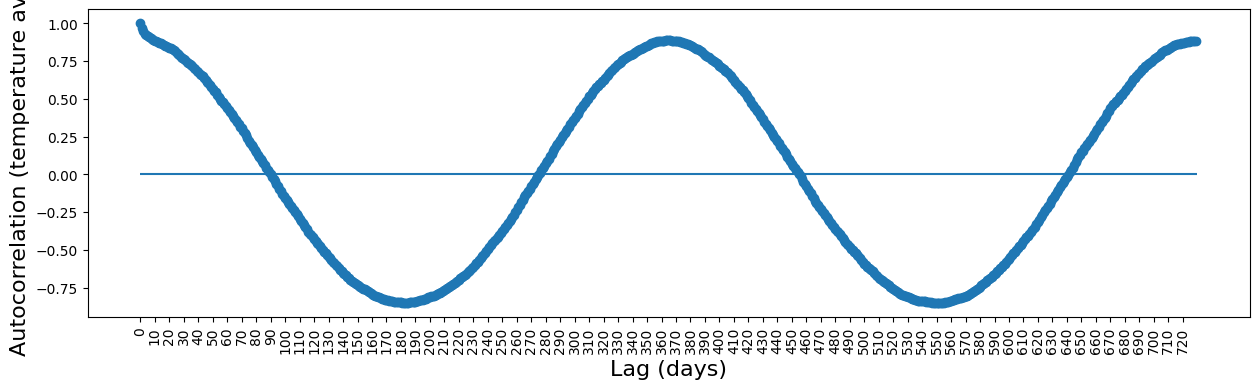

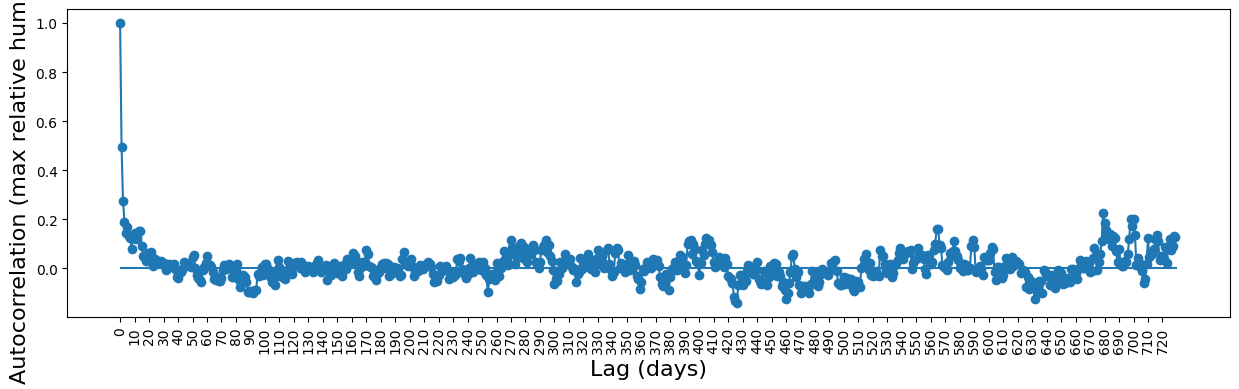

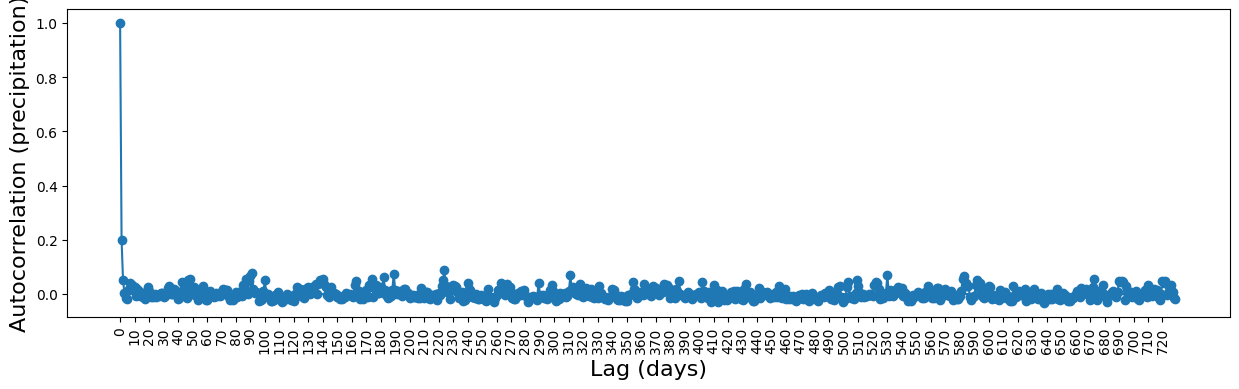

In [38]:
# LEAVE AS-IS

# Plot max temperature auto-correlation
plot_auto_correlations(auto_correlations_temp_max, ylabel="Autocorrelation (temperature max)")

# Plot avg temperature auto-correlation
plot_auto_correlations(auto_correlations_temp_avg, ylabel="Autocorrelation (temperature avg)")

# Plot max relative humidity auto-correlation
plot_auto_correlations(auto_correlations_relhumidity, ylabel="Autocorrelation (max relative humidity)")

# Plot precipitation auto-correlation
plot_auto_correlations(auto_correlations_rainfall, ylabel="Autocorrelation (precipitation)")

<font size="+1" color="red">Replace this cell with a brief commentary on what you see on these plots. (1) What do these autocorrelations indicate about the temperature data? (2) What do these autocorrelations indicate about the humidity data? (3) What do these autocorrelations indicate about the precipitation data? (4) Based on what you see in the autocorrelation plot, what is more unpredictable, humidity or precipitation?</font>

#### Comment
**********************


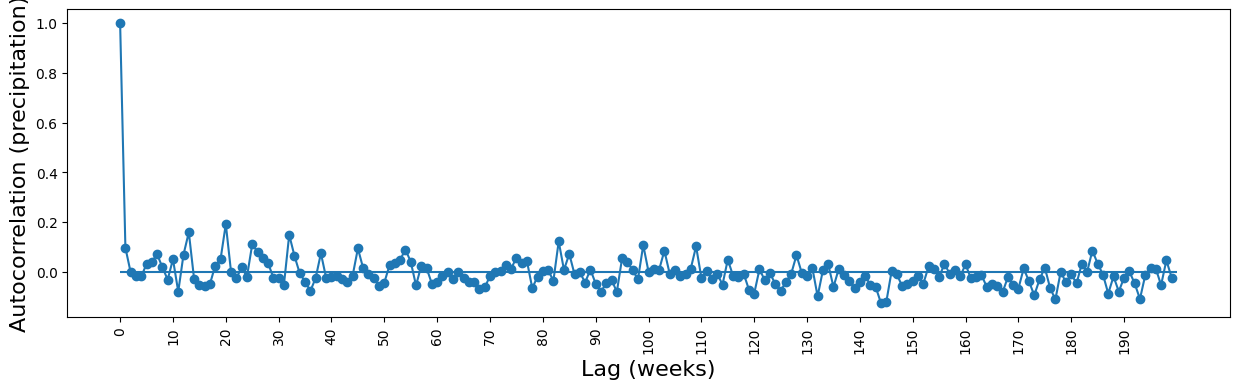

In [39]:
# LEAVE AS-IS

auto_correlations_rainfall_week = compute_autocorrelations(weather_per_floating_week['rainfall'], 200)

plot_auto_correlations(auto_correlations_rainfall_week, xlabel='Lag (weeks)', ylabel="Autocorrelation (precipitation)")

<font size="+1" color="red">Replace this cell with a brief commentary on what you see on this plot. Do you think the correlations you observe in the weekly time series of precipitation (aside from the one at lag=1) come from a real phenomenon, or are spurious? Why?</font>

#### Comment
**********************

## 2.2. Prepare a system of equations to learn an auto-regressive model

<font size="+1" color="red">Replace this cell with your code for "prepare_matrices"</font>

In [40]:
def prepare_matrices(series, lags):
    y = []
    X = []
    
    for lag in lags:
        assert(lag > 0)
        assert(lag < len(series))
    
    for i in range(np.max(lags), len(series)):
        # YOUR CODE HERE
        row = []
        for lag in lags:
            row.append(series[i-lag])
            
        # Skipp the row that contains NaN
        if any(isinstance(v, float) and math.isnan(v) for v in row + [series[i]]):
            continue
        
        X.append(row)
        y.append(series[i])
        
    return X, y

In [41]:
# LEAVE AS-IS

X, y = prepare_matrices([11, 15, 32, 37, 52, 54, 70, 89], [2, 3])
print("X=%s" % X)
print("y=%s" % y)

X=[[15, 11], [32, 15], [37, 32], [52, 37], [54, 52]]
y=[37, 52, 54, 70, 89]


In [42]:
# LEAVE AS-IS

X, y = prepare_matrices([11, 15, 32, np.nan, 52, 54, 70, 89], [2, 3])
print("X=%s" % X)
print("y=%s" % y)

X=[[32, 15], [54, 52]]
y=[52, 89]


## 2.3. Perform forecasts

In [43]:
# LEAVE AS-IS

def perform_forecast(series, lags):

    # Prepare matrices for linear regression
    X, y = prepare_matrices(series, lags)

    # Perform forecast
    linear_regressor = LinearRegression()
    linear_regressor.fit(X,y)
    y_pred = linear_regressor.predict(X)

    # Compute forecasting error
    # Root mean squared error, normalized
    rmse = math.sqrt(mean_squared_error(y, y_pred))/(np.max(y)-np.min(y))
    
    # Return: observed, predicted, error
    return (y, y_pred, rmse)

def plot_forecast(y, y_pred, xlabel="Period", ylabel="", nrmsd=-1):

    plt.figure(figsize=(15,4))
    
    plt.plot(y, '.-', linewidth=4, color='gray', label='Observed')
    plt.plot(y_pred, '--', linewidth=2, color='green', label=('Model (NRMSD=%.2f)' % nrmsd if nrmsd > 0 else 'Model'))
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend()
    plt.show()

<font size="+1" color="red">Replace this cell with your choice for "lags_monthly_temperature"</font>

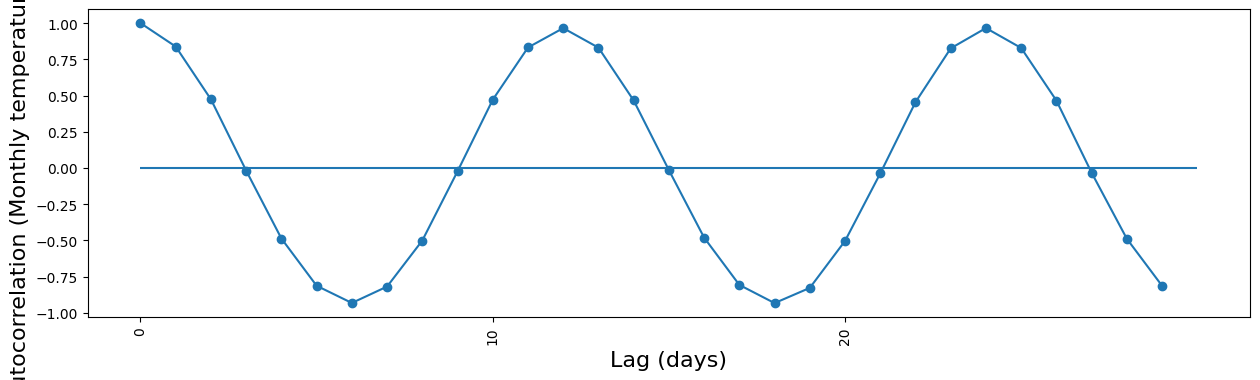

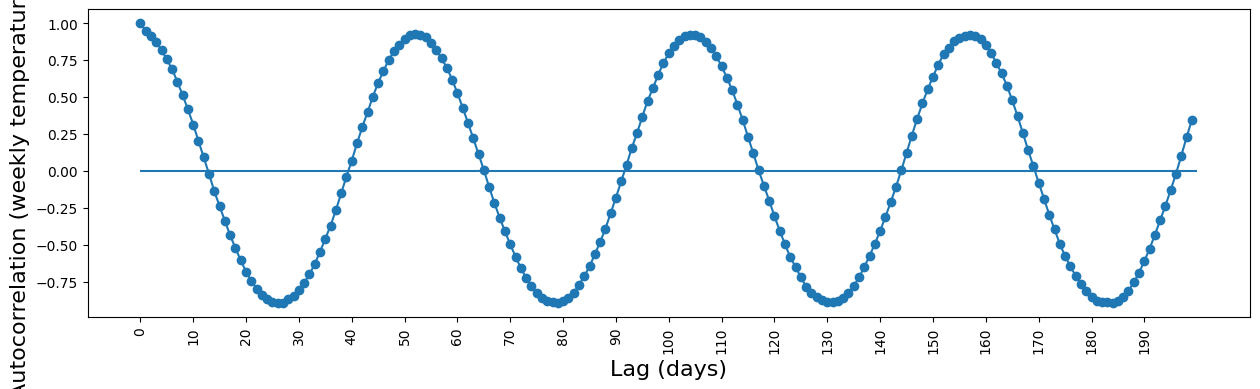

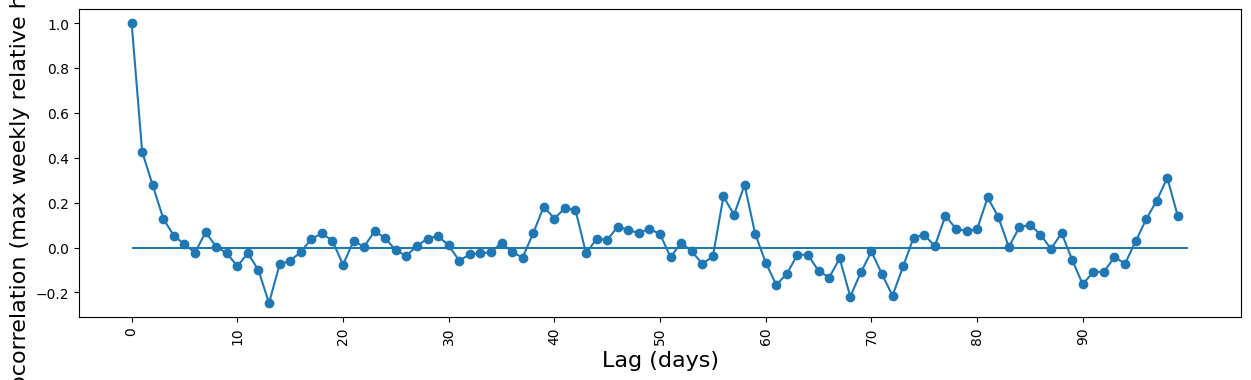

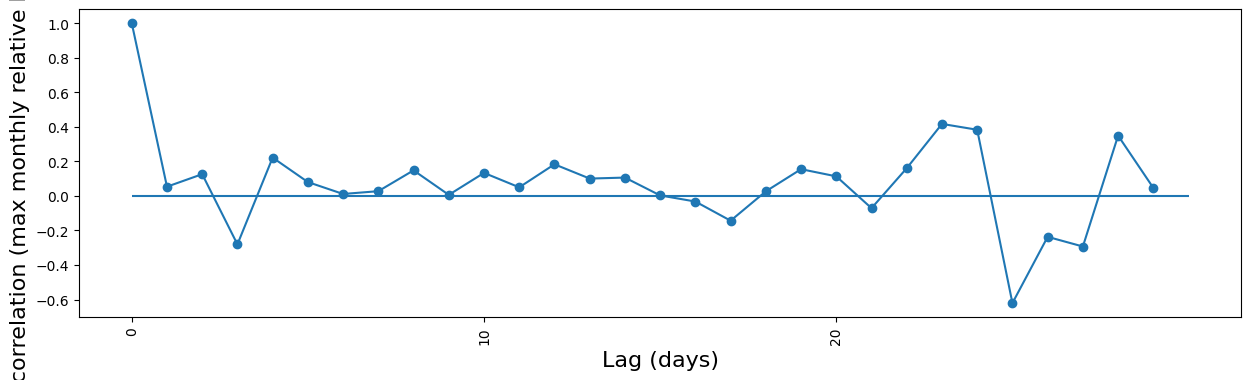

In [44]:
# Here I add the autocorrelation plots where were not included before 
auto_correlations_temp_avg_month = compute_autocorrelations(weather_per_month['temp_avg'], 30)
plot_auto_correlations(auto_correlations_temp_avg_month, ylabel="Autocorrelation (Monthly temperature avg)")

auto_correlations_temp_avg_week = compute_autocorrelations(weather_per_floating_week['temp_avg'], 200)
plot_auto_correlations(auto_correlations_temp_avg_week, ylabel="Autocorrelation (weekly temperature avg)")

auto_correlations_humudity_max_week = compute_autocorrelations(weather_per_floating_week['relhumidity_max'], 100)
plot_auto_correlations(auto_correlations_humudity_max_week, ylabel="Autocorrelation (max weekly relative humidity)")

auto_correlations_humudity_max_month = compute_autocorrelations(weather_per_month['relhumidity_max'], 30)
plot_auto_correlations(auto_correlations_humudity_max_month, ylabel="Autocorrelation (max monthly relative humidity)")

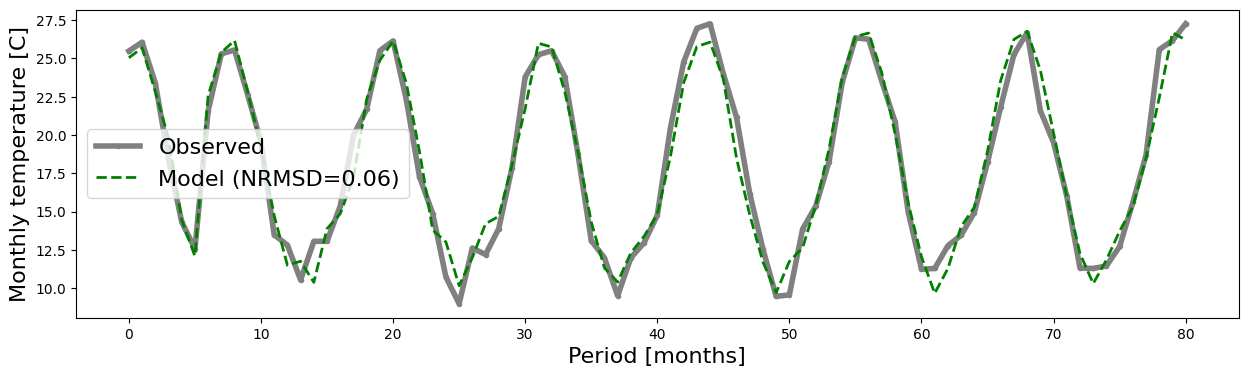

In [45]:
# LEAVE AS-IS
lags_monthly_temperature = [1, 2, 12, 24]
(y, y_pred, nrmsd) = perform_forecast(weather_per_month['temp_avg'],
                                      lags_monthly_temperature)

plot_forecast(y, y_pred,
              xlabel="Period [months]",
              ylabel="Monthly temperature [C]",
              nrmsd=nrmsd)

<font size="+1" color="red">Replace this cell with code and plots predicting: (1) weekly temperature, (2) daily temperature. Always use up to 4 lags, and try to find the lags leading to the smaller error.</font>

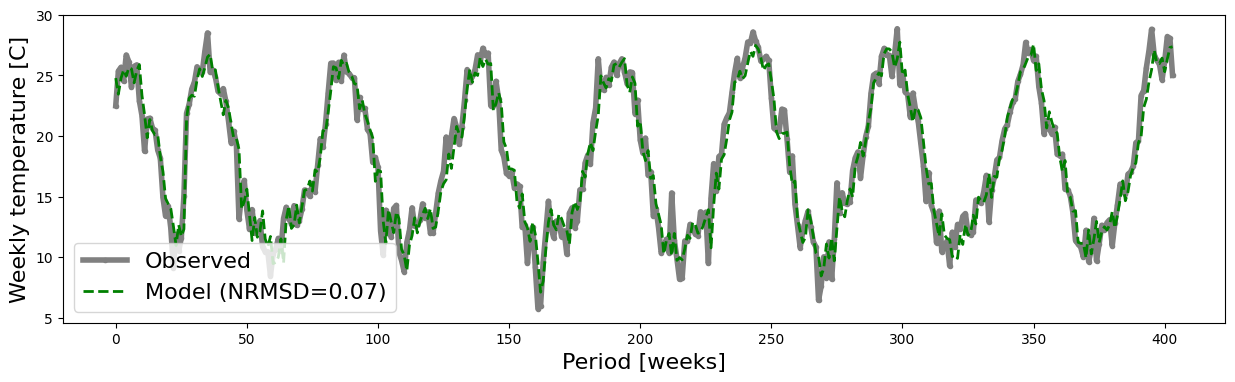

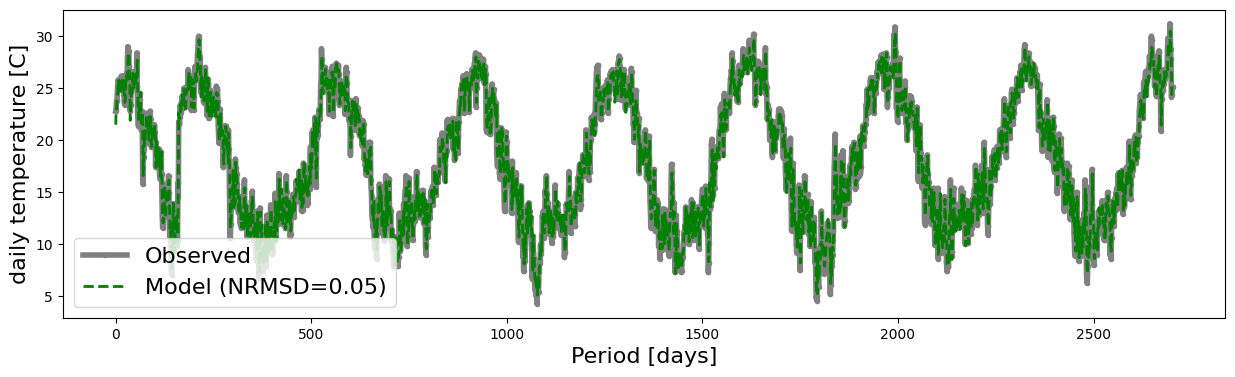

In [46]:
lags_weekly_temperature = [1, 2, 52]
(y_w, y_pred_w, nrmsd) = perform_forecast(weather_per_floating_week['temp_avg'],
                                      lags_weekly_temperature)

plot_forecast(y_w, y_pred_w,
              xlabel="Period [weeks]",
              ylabel="Weekly temperature [C]",
              nrmsd=nrmsd)

# Use the previous 4 days as lags
lags_daily_temperature = [1, 365]
(y_d, y_pred_d, nrmsd) = perform_forecast(weather['temp_avg'],
                                      lags_daily_temperature)

plot_forecast(y_d, y_pred_d,
              xlabel="Period [days]",
              ylabel="daily temperature [C]",
              nrmsd=nrmsd)


<font size="+1" color="red">Replace this cell with a brief commentary on what you observe when predicting temperature.</font>

#### Comment
*************

<font size="+1" color="red">Replace this cell with code and plots predicting: (1) monthly relative humidity, i.e., monthly average of maximum relative humidity, (2) weekly relative humidity, (3) daily relative humidity. Always use up to 4 lags, and try to find the lags leading to the smaller error.</font>

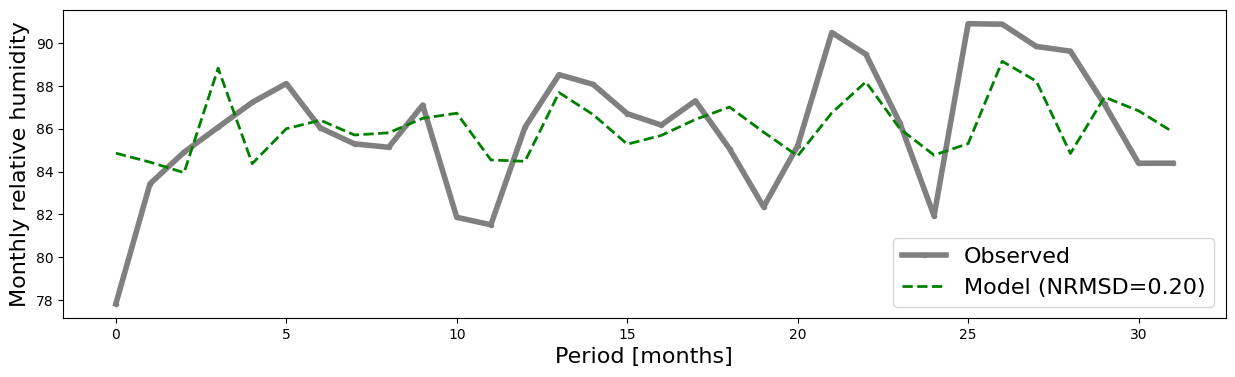

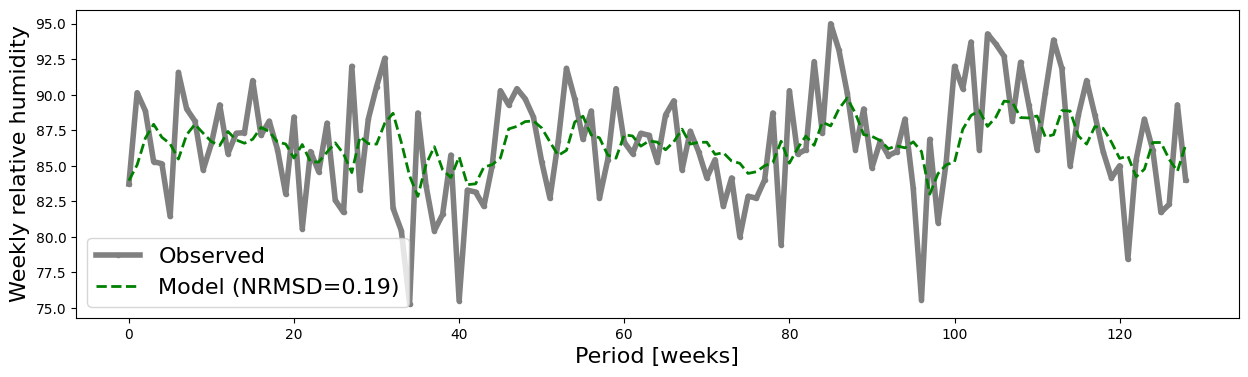

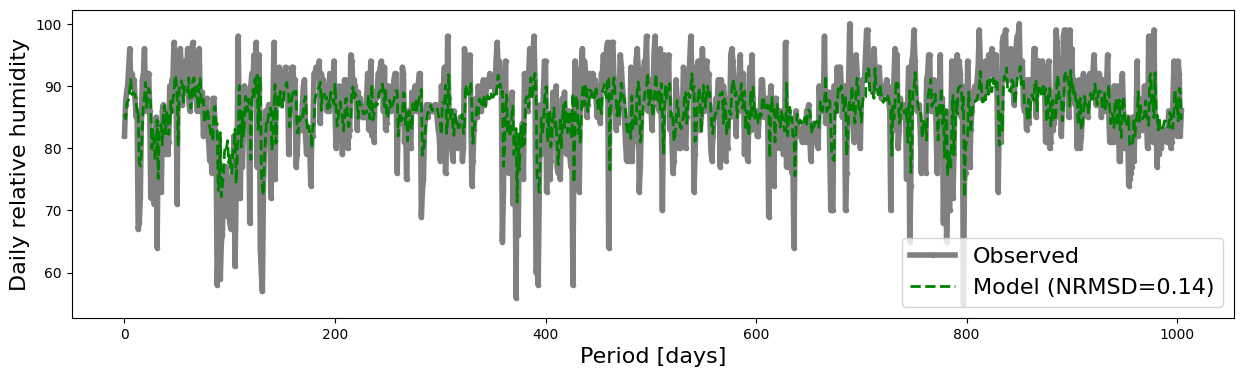

In [47]:
# 1. monthly average of maximum relative humidity
lags_monthly_humidity = [1, 2, 3, 4]
[hum_m, hum_m_pred, nrmsd1] = perform_forecast(weather_per_month['relhumidity_max'], lags_monthly_humidity)

# 2. weekly relative humidity
lags_weeky_humidity = [1, 2, 3, 4]
[hum_w, hum_w_pred, nrmsd2] = perform_forecast(weather_per_floating_week['relhumidity_max'], lags_monthly_temperature)

# 3. daily relative humudity
lags_monthly_temperature = [1, 2, 4, 23]
[hum_d, hum_d_pred, nrmsd3] = perform_forecast(weather['relhumidity_max'], lags_monthly_temperature)

# Plot
plot_forecast(hum_m, hum_m_pred,
              xlabel="Period [months]",
              ylabel="Monthly relative humidity",
              nrmsd=nrmsd1)

plot_forecast(hum_w, hum_w_pred,
              xlabel="Period [weeks]",
              ylabel="Weekly relative humidity",
              nrmsd=nrmsd2)

plot_forecast(hum_d, hum_d_pred,
              xlabel="Period [days]",
              ylabel="Daily relative humidity",
              nrmsd=nrmsd3)

<font size="+1" color="red">Replace this cell with a brief commentary, in your own words, on what you observe when trying to predict relative humidity, in comparison with trying to predict temperature.</font>

#### Comment
*****

<font size="+2" color="red">Additional results: cross correlations</font>

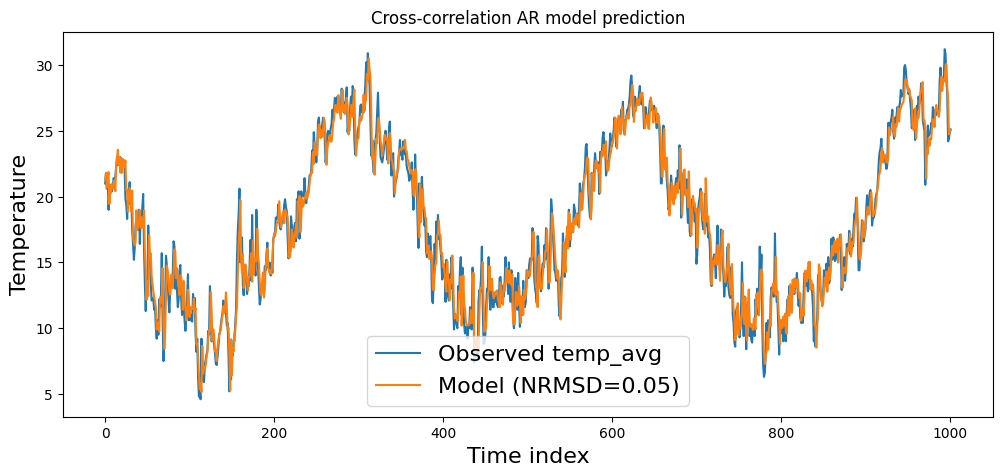

In [48]:
def comput_cross_correlations(df, var_to_predict, vars_to_use, lags):
    X = []
    y = []

    for i in range(max(lags), len(weather)):
        row = []
        skip = False
        for lag in lags:
            for var in vars_to_use:
                val = df[var].iloc[i-lag]
                if np.isnan(val):
                    skip = True
                row.append(val)
                
        # if original value has Nan, skip
        val_y = df[var_to_predict].iloc[i]
        if np.isnan(val_y):
            skip = True
            
        if skip:
            continue
        X.append(row)
        y.append(df[var_to_predict].iloc[i])

    # AR
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    
    # RMSE
    rmse = math.sqrt(mean_squared_error(y, y_pred))/(np.max(y)-np.min(y))
    return y, y_pred, rmse


var_to_predict = 'temp_avg'
vars_to_use = ['temp_min','temp_avg','temp_max','rainfall','relhumidity_min','relhumidity_max','windspeed_avg','windspeed_gusts']
lags = [1, 2, 3, 4]
y_true, y_pred, nrmsd = comput_cross_correlations(weather, var_to_predict, vars_to_use, lags)

plt.figure(figsize=(12,5))
plt.plot(y_true, label='Observed temp_avg', )
plt.plot(y_pred, label=('Model (NRMSD=%.2f)' % nrmsd if nrmsd > 0 else 'Model'))
plt.xlabel('Time index')
plt.ylabel('Temperature')
plt.title('Cross-correlation AR model prediction')
plt.legend()
plt.show()

<font size="+2" color="#003300">I hereby declare that I completed this practice myself, that my answers were not written by an AI-enabled code assistant, and that except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>